# ADL Model Tests

Summary : 
ADL trained using RELU activations obviously clips  the lower bound to zero , producing zero response to negative signal. This can be seen from range of denoised results being [0,1]. Plots also show the same. 
Hence, all 'denoiser' related activations having role in producing the denoised output need to be changed to 'Tanh'. 

The following results show that replacing the RELU & SIGMOID with tanh activation improves the denoised image significantly. Error reduces from 0.3 to 0.05 
Moreover, removing batch normalisation reduces the train loss marginally, but reduces val losses significantly. 0.12 to 0.04

In [169]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install -qq rich pytorch-lightning==1.7.7 scikit-image==0.19.2
# !git clone https://github.com/jayantb1019/adl_seismic.git
# !mkdir -p /content/adl_seismic/data
# !unzip /content/drive/MyDrive/faciesmark.zip -d /content/adl_seismic/data/.
# !cp /content/drive/MyDrive/denoiser_20230213_epoch=49-step=27600.ckpt /content/denoiser_20230213_epoch=49-step=27600.ckpt
# !cp /content/drive/MyDrive/discriminator_20230213_epoch=49-step=27600.ckpt /content/discriminator_20230213_epoch=49-step=27600.ckpt

In [170]:
import numpy as np 
import pytorch_lightning as pl 
import torch 
import yaml

import matplotlib.pyplot as plt

import sys 
sys.path.append("../models")
sys.path.append("../utils")
sys.path.append("../noise")
sys.path.append("../lightning_logs")
sys.path.append("../data")

# sys.path.append(r"..\models")
# sys.path.append(r"..\utils")
# sys.path.append(r"..\lightning_logs")
# sys.path.append(r"..\data")


from adl import Efficient_U
from random_noise import add_noise

In [171]:


CONFIG_PATH= '../config/config_adl_faciesmark.yaml'
test_data_path = '../data/faciesmark/test_once/test2_seismic.npy'
# ckpt_path = '/local1/workspace/adl_seismic/lightning_logs/denoiser/adl_16_02_2023_17_44_28/checkpoints/epoch=49-step=27600.ckpt'
ckpt_path = '/local1/workspace/adl_seismic/lightning_logs/denoiser/adl_27_02_2023_18_16_16/checkpoints/epoch=59-step=27360.ckpt'

# CONFIG_PATH = r'Z:\experiments_feb\config\config_adl_faciesmark.yaml'
# test_data_path = r'Z:\experiments_feb\data\faciesmark\test_once\test2_seismic.npy'
# ckpt_path = r'Z:\experiments_feb\lightning_logs\denoiser_20230213_epoch=49-step=27600.ckpt'

def get_config(config_path) : 
    # read config file 
    with open(config_path, 'r') as f : 
        config = yaml.safe_load(f)
    f.close()
    return config

config = get_config(CONFIG_PATH)


In [172]:
test_data = np.load(test_data_path)
noisy_test_data = add_noise(test_data, mode='gaussian', mean=0,noise_factor=0.01)
model = Efficient_U.load_from_checkpoint(checkpoint_path=ckpt_path, config=config)


In [173]:
random_iline_no = np.random.randint(600)
random_iline_no

585

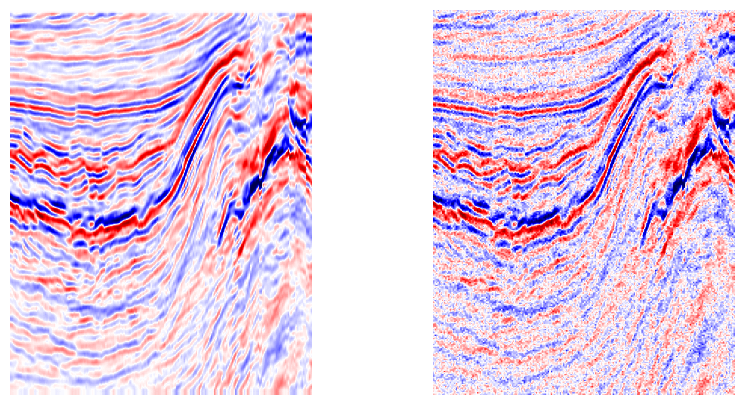

In [174]:
fig, ax = plt.subplots(ncols=2, figsize=(5*2, 5))

clean_inline = test_data[random_iline_no]
noisy_inline = noisy_test_data[random_iline_no]

kwargs = dict(cmap = 'seismic', vmin = -1, vmax = 1)

ax[0].imshow(clean_inline.T, **kwargs)
ax[0].axis('off')
ax[1].imshow(noisy_inline.T, **kwargs)
ax[1].axis('off')
plt.show()

In [175]:
# padded input 
test_pd = np.zeros((noisy_test_data.shape[0],noisy_test_data.shape[1],noisy_test_data.shape[2] + 1 ))
display(test_pd.shape)

test_pd[:,:,:noisy_test_data.shape[2]] = noisy_test_data

test_pd = test_pd.transpose(0,2,1)

(601, 200, 256)

In [176]:
device = 'cuda'
torch.cuda.empty_cache()
import gc 
gc.collect()
noisy_test_tensor = torch.from_numpy(np.expand_dims(test_pd, axis=1)).float().to(device)
model = model.to(device)
model.eval()

with torch.no_grad() : 

    # original
    denoised , _ , _ = model(noisy_test_tensor[:10])
    denoised = denoised.clamp(-1,1)

    # polarity reversed
    denoised_r, _, _ = model(-1 * noisy_test_tensor[:10])
    denoised_r = (-1* denoised_r).clamp(-1,1)

    # # horizontal flipped 
    # denoised_r, _, _ = model(torch.flip(noisy_test_tensor[:10],))
    # denoised_r = (-1* denoised_r).clamp(-1,1)

    
    denoised = (denoised + denoised_r) /2.0

In [177]:
denoised.shape

torch.Size([10, 1, 256, 200])

In [178]:
torch.round(torch.min(denoised)) , torch.max(denoised)

(tensor(-1., device='cuda:0'), tensor(1., device='cuda:0'))

In [179]:
denoised = denoised.to('cpu').numpy()

In [180]:
denoised = np.squeeze(denoised)[:,:,:256]

In [181]:
denoised.shape

(10, 256, 200)

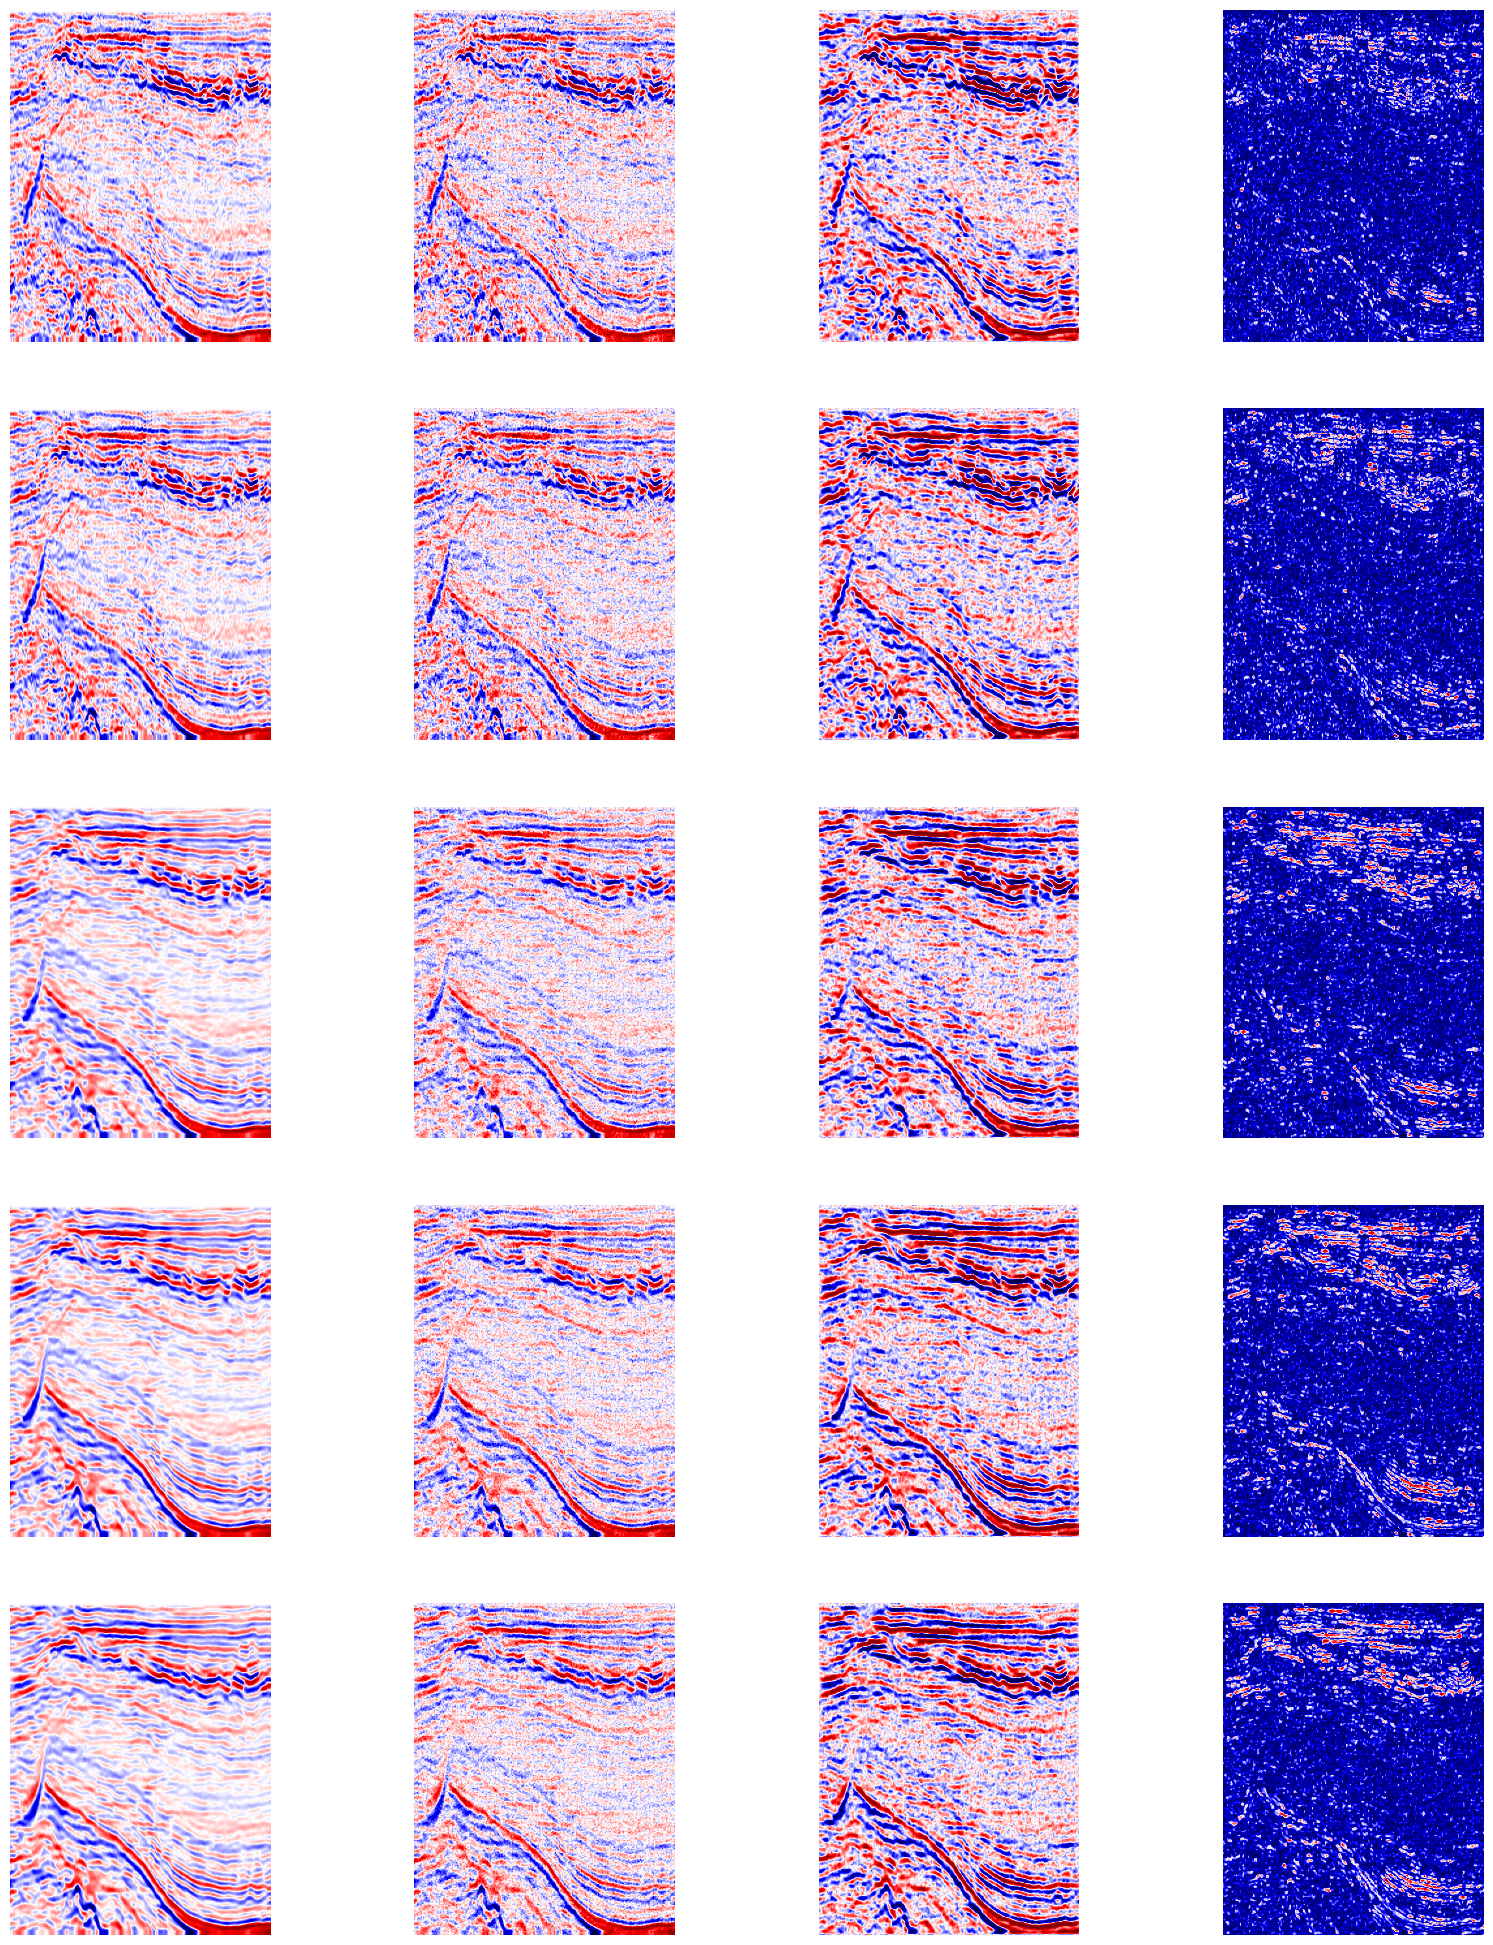

In [182]:
fig, ax = plt.subplots(ncols=4, nrows = 5, figsize=(5*4, 5 * 5))

for i in range(5) : 
    clean_inline = test_data[i]
    noisy_inline = noisy_test_data[i]
    denoised_inline = denoised[i]

    diff = np.abs(denoised_inline[:-1,:] - clean_inline.T)

    kwargs = dict(cmap = 'seismic')

    ax[i,0].imshow(clean_inline.T, **kwargs)
    ax[i,0].axis('off')
    ax[i,1].imshow(noisy_inline.T, **kwargs)
    ax[i,1].axis('off')
    ax[i,2].imshow(denoised_inline, **kwargs)
    ax[i,2].axis('off')
    ax[i,3].imshow(diff, **kwargs)
    ax[i,3].axis('off')
plt.show()

In [206]:
# Reflection padding and general padding tests 

import torch 
import torch.nn as nn 

data = torch.randn((128,1,34,34))

def pad_(data, factor = 8) : 
    '''Check if the dimensions of data are a multiple of 32. If not, pad , also add reflection padding = half of data size to remove any edge effects'''

    b,c,h,w = data.shape 

    h_, w_ = h ,w

    if h % factor : 
        h_ = ( h// factor + 1 ) * factor

    if w % factor : 
        w_ = ( w// factor + 1 ) * factor

    
    pad = torch.zeros((b,c, h_,w_))

    pad[:,:,:h, :w] = data 

    refpad = nn.ReflectionPad2d((w_//2 , w_//2 , h_//2 , h_//2 ))

    return refpad(pad), h, w 

In [207]:
data_refpad, h , w = pad_(data, factor=8)
data_refpad.shape, h, w

(torch.Size([128, 1, 80, 80]), 34, 34)

In [208]:
def unpad_(data, h, w) : 

    b,c, h_refpad, w_refpad = data.shape 

    data_unrefpad = data[:, :, h_refpad//4 : h_refpad//4 + h, w_refpad//4 : w_refpad // 4 + w ]


    return data_unrefpad

data_original = unpad_(data_refpad, h,w)

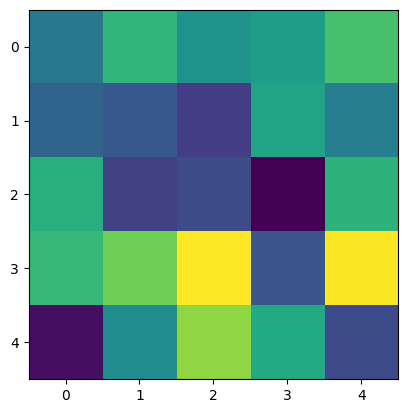

In [212]:
# horizontal flip 

data = torch.randn((1,5,5))
plt.imshow(data[0])

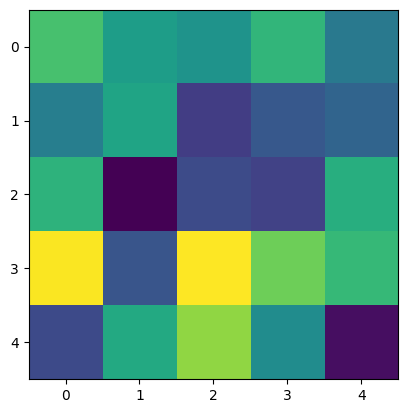

In [224]:
from torchvision.transforms import RandomHorizontalFlip
flipper = RandomHorizontalFlip(p=1)
flipped = flipper(data)
plt.imshow(flipped[0])